In [10]:
import os
from functools import partial

os.environ["JAX_ENABLE_X64"] = "True"

import jax.numpy as jnp
import typer
from jax import Array, jit, random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.draw import draw_gaussian, draw_spergel
from bpd.io import save_dataset
from bpd.likelihood import gaussian_image_loglikelihood
from bpd.pipelines import pipeline_interim_samples_one_galaxy
from bpd.prior import interim_gprops_logprior
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_galaxy_params_skew,
)
from bpd.utils import DEFAULT_HYPERPARAMS, MAX_N_GALS_PER_GPU, process_in_batches

from bpd.chains import run_inference_nuts



In [11]:
import matplotlib.pyplot as plt 

from jax.scipy import stats

In [12]:
def _init_fnc(key: PRNGKeyArray, data: Array, true_params: dict):
    image = data
    assert image.ndim == 2
    assert image.shape[0] == image.shape[1]
    flux = image.sum()

    k1, k2, k3, k4 = random.split(key, 4)

    tlhlr = true_params["lhlr"]
    lhlr = random.uniform(k1, shape=(), minval=tlhlr - 0.015, maxval=tlhlr + 0.015)

    te1 = true_params["e1"]
    e1 = random.uniform(k2, shape=(), minval=te1 - 0.1, maxval=te1 + 0.1)

    te2 = true_params["e2"]
    e2 = random.uniform(k3, shape=(), minval=te2 - 0.1, maxval=te2 + 0.1)
    
    nu = random.uniform(k4, shape=(), minval=0.4, maxval=0.6)
    
    return {
        "lf": jnp.log10(flux),
        "lhlr": lhlr,
        "e1": e1,
        "e2": e2,
        "dx": 0.0,
        "dy": 0.0,
        'nu': nu,
    }

In [13]:
seed: int = 91
n_gals: int = 100
n_samples_per_gal: int = 300
sigma_e_int: float = 0.3
g1: float = 0.02
g2: float = 0.0
slen: int = 63
fft_size: int = 256
background: float = 1.0
initial_step_size: float = 0.01


In [14]:
rng_key = random.key(seed)
pkey, nkey, gkey = random.split(rng_key, 3)

# galaxy parameters from prior
galaxy_params = sample_galaxy_params_skew(
    pkey, n=n_gals, g1=g1, g2=g2, **DEFAULT_HYPERPARAMS
)
assert galaxy_params["x"].shape == (n_gals,)
assert galaxy_params["e1"].shape == (n_gals,)

In [15]:
# now get corresponding target images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
draw_params["hlr"] = 10 ** draw_params.pop("lhlr")
target_images = get_target_images(
    nkey,
    draw_params,
    background=background,
    slen=slen,
    draw_type="exponential",
)
assert target_images.shape == (n_gals, slen, slen)

# interim samples are on 'sheared ellipticity'
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)
true_params["dx"] = jnp.zeros_like(true_params["x"])
true_params["dy"] = jnp.zeros_like(true_params["y"])
fixed_params = {
    "x": true_params.pop("x"),
    "y": true_params.pop("y"),
}

In [16]:
def logtarget(params, *, data, fixed_params, sigma_e_int, slen, fft_size, background):

    nu = params.pop('nu')

    logprior = interim_gprops_logprior(params, sigma_e=sigma_e_int, free_flux_hlr=True, free_dxdy=True)
    _draw_fnc = partial(draw_spergel, nu=nu, slen=slen, fft_size=fft_size) 

    # account for nu
    # logprior += stats.uniform.logpdf(nu, -0.85, 4.0) # galsim permitted values
    logprior += stats.norm.logpdf(nu, 0.5, 0.1)

    loglikelihood = gaussian_image_loglikelihood(params, data, fixed_params, 
                                                 draw_fnc=_draw_fnc, background=background, free_flux_hlr=True, free_dxdy=True)

    return logprior + loglikelihood


def pipe(rng_key, data, init_params, fixed_params, *, logtarget, n_samples=100,):
    _logtarget = partial(logtarget, fixed_params=fixed_params)
    _do_inference = partial(run_inference_nuts, logtarget=_logtarget, 
                            n_samples=n_samples, initial_step_size=0.01, max_num_doublings=5)
    return _do_inference(rng_key, data, init_params)

In [17]:
_logtarget = partial(logtarget, sigma_e_int=0.3, slen=slen, fft_size=fft_size, background=background)
_pipe = jit(partial(pipe, logtarget=_logtarget, n_samples=500))

In [18]:
ikey, rkey = random.split(gkey, 2)

rkeys = random.split(rkey, n_gals)
ikeys = random.split(ikey, n_gals)

In [19]:
# get initial parameters
init_params= vmap(_init_fnc)(ikeys, target_images, true_params)

init_params['nu'].shape

(100,)

In [20]:
# compilation on single target image
_ = _pipe(
    rkeys[0],
    target_images[0],
    {k: v[0] for k, v in init_params.items()},
    {k: v[0] for k, v in fixed_params.items()},
)

In [21]:
vpipe = vmap(_pipe)

In [22]:
samples = vpipe(
    rkeys,
    target_images,
    init_params,
    fixed_params
)

In [23]:
samples['nu'].shape

(100, 500)

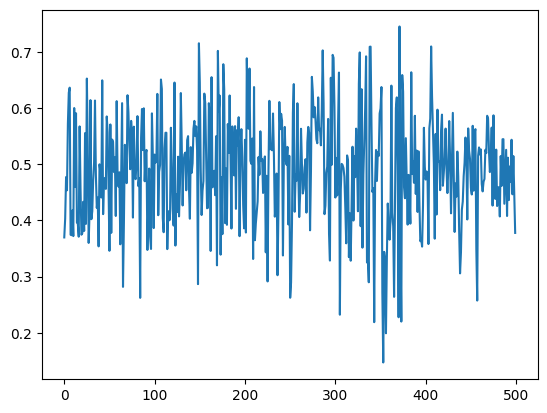

In [24]:
plt.plot(samples['nu'][51])

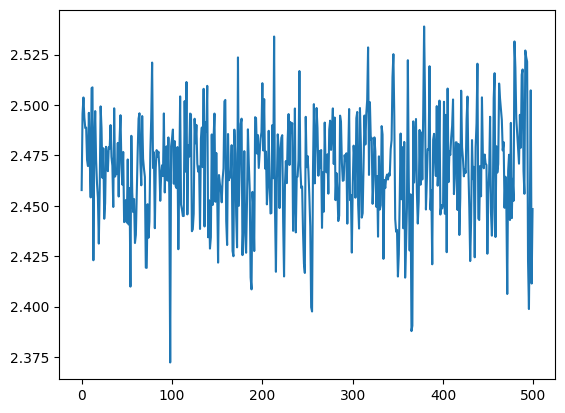

In [25]:
plt.plot(samples['lf'][51])

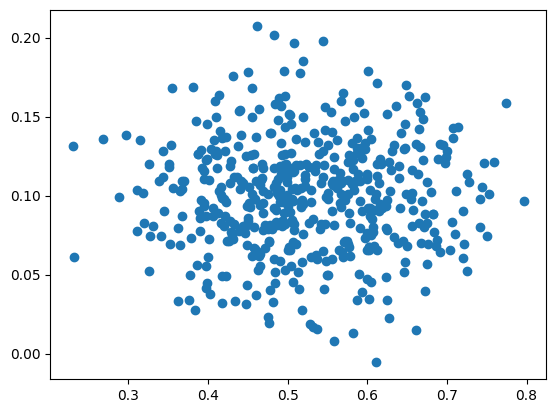

In [28]:
plt.scatter(samples['nu'][12], samples['e2'][12])

# Check convergence

In [43]:
# lets use 400 total galaxies to check for convergence
import numpy as np 
from tqdm import tqdm

from arviz import ess
from blackjax.diagnostics import potential_scale_reduction
def get_ess_all(samples: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    """Obtain ESS for all chains and parameters."""
    print("INFO: Computing ESS...")
    n_gals, n_chains_per_gal, n_samples_per_gal = samples["lf"].shape

    n_samples = n_chains_per_gal * n_samples_per_gal
    ess_dict = {}

    for ii in tqdm(range(n_gals)):
        params = {k: v[ii] for k, v in samples.items()}
        value = ess(params)

        for k in samples:
            kval = value[k].data.item() / n_samples
            if k not in ess_dict:
                ess_dict[k] = [kval]
            else:
                ess_dict[k].append(kval)
    ess_dict = {k: np.array(v) for k, v in ess_dict.items()}
    return ess_dict


def get_rhat_all(samples: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    """Obtain r-hats for all chains and parameters."""
    print("INFO: Computing R-hats...")
    n_gals, n_chains_per_gal, n_samples = samples["lf"].shape

    rhat_dict = {}
    for p in samples:
        rhat = []
        for ii in tqdm(range(n_gals)):
            chains = samples[p][ii]
            assert chains.shape == (n_chains_per_gal, n_samples)
            rhat.append(potential_scale_reduction(chains))
        rhat_dict[p] = np.array(rhat)

    return rhat_dict

In [30]:
ikeys = random.split(ikey, (n_gals, 4))
rkeys = random.split(rkey, (n_gals, 4))

In [31]:
# get initial parameters
init_params= vmap(vmap(_init_fnc, in_axes=(0, None, None)))(ikeys, target_images, true_params)

init_params['nu'].shape

(100, 4)

In [32]:
vpipe = vmap(vmap(_pipe, in_axes=(0, None, 0, None)))

In [33]:
samples = vpipe(
    rkeys,
    target_images,
    init_params,
    fixed_params
)

In [34]:
samples['nu'].shape

(100, 4, 500)

In [36]:
# save using pickle 
import pickle
with open('samples_nu2.pkl', 'wb') as fp:
    pickle.dump(samples, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
# check convernge of each param
ess_dict = get_ess_all(samples)

INFO: Computing ESS...


100%|██████████| 100/100 [00:01<00:00, 83.56it/s]


In [46]:
rhat_dict = get_rhat_all(samples) 

INFO: Computing R-hats...


100%|██████████| 100/100 [00:00<00:00, 1061.03it/s]


In [51]:
for p in ess_dict:
    print(p)
    print(np.median(ess_dict[p]), np.mean(ess_dict[p]),  np.min(ess_dict[p]))
    print()

dx
1.0546209459483 1.0685894985948237 0.7651899466834704

dy
1.0378443793524061 1.057440289477544 0.7760658672606309

e1
1.0123463908950128 1.01917544965443 0.6439456304643713

e2
1.0243261049452244 1.0184790404563115 0.6147803541201777

lf
0.7559867862689423 0.7804291981841135 0.5451550986461776

lhlr
0.6885143216681329 0.7199791299559267 0.4528714359618318

nu
1.045636399210324 1.0658742888598765 0.6362905850809464



In [56]:
rhat_dict['dx']

array([1.00068609, 0.99972128, 0.99946165, 0.99907527, 0.99975973,
       1.00052663, 0.99955319, 0.9994141 , 0.99943226, 0.99924814,
       0.99950852, 0.99913251, 0.99907089, 0.99953516, 0.99997354,
       0.99992864, 0.99985013, 0.99904869, 0.99951245, 1.00140486,
       0.99950369, 1.00013786, 0.99965861, 1.0012618 , 0.99928947,
       0.99960497, 0.99927399, 1.00094   , 0.99974491, 1.00058087,
       0.99939884, 1.00003864, 0.9991226 , 0.99925595, 0.99917557,
       1.00049183, 0.99992778, 0.99945452, 0.99923881, 0.99984491,
       0.99932886, 0.99976013, 1.00097152, 0.99951916, 0.99962188,
       1.00120587, 0.99908686, 0.99939269, 0.99968173, 0.99915898,
       1.00232082, 1.00044152, 0.99908289, 0.99960973, 0.99956588,
       0.99985506, 1.00175027, 1.00275459, 0.99928619, 0.99946235,
       0.99986684, 0.99974786, 0.99901698, 1.00001089, 0.99966729,
       0.99990411, 0.99996116, 1.00044652, 1.00002566, 0.99923692,
       0.99964816, 1.00012023, 0.99927287, 0.99993201, 1.00121